# **Basic Environment**

### **Imports**

In [1]:
### Utility
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Torch
import torch
from torch import nn
from torch import optim
### Torch RL
# Env
from torchrl.envs.libs import UnityMLAgentsEnv
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from torchrl.envs.utils import step_mdp, check_env_specs
from torchrl.envs import TransformedEnv, Stack, ExcludeTransform, CatTensors, AutoResetTransform

# Data Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement


# Model
from model import create_policy, create_value
# Train Util
from train_util import make_loss_module, compute_trajectory_metrics, loss_dict, Stopwatch, Logger, Checkpointer, compute_single_trajectory_metrics, load_model
# Inspect Results
from result import plot, play, test
# Import env/system config
from config import (
    ENV_PATH, LOG_KEYS, LOG_INDEX, BEST_METRIC_KEY,
    ROOT_KEY, OBSERVATION_KEY, ACTION_KEY, 
    ACTION_SHAPE, OBSERVATION_SHAPE,
    LOG_PATH, CKPT_PATH, MODEL_PATH,RESULTS_PATH,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## **Create Env**

In [2]:
class ReCreateWrapper(UnityMLAgentsEnv):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.kwargs = kwargs

    def _reset(self, tensordict, **kwargs):
        super().close()
        super().__init__(**self.kwargs)
        return super()._reset(tensordict, **kwargs)

def create_unity_env(graphics=False, **kwargs):
    try:
        env.close()
    except:
        pass
    
    # 99% percent of gambler quit right before they're about to hit it big
    ATTEMPTS = 10
    for i in range(ATTEMPTS):
        try:
            env = ReCreateWrapper(
                file_name=ENV_PATH, worker_id=np.random.randint(10000), 
                no_graphics=(not graphics), **kwargs,
                device="cpu",
            )
            break
        except:
            pass
        if i + 1 == ATTEMPTS: raise RuntimeError("Couldn't Create Environment")
    
    return TransformedEnv(env)

def create_env(graphics=False, time_scale = 1, **kwargs):
    # Time scale
    if time_scale != 1:
        engine_config_channel = EngineConfigurationChannel()
        env = create_unity_env(graphics, **kwargs, side_channels=[engine_config_channel])
        engine_config_channel.set_configuration_parameters(time_scale=time_scale)
    else:
        env = create_unity_env(graphics, **kwargs)

    return env

In [3]:
def print_specs(env):
    print("action_spec:", env.action_spec)
    print("reward_spec:", env.reward_spec)
    print("done_spec:", env.done_spec)
    print("observation_spec:", env.observation_spec)

env = create_env(time_scale=1)
check_env_specs(env)
print_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

### **Inspect**

Action Space: vector dim 7 and one hot categorical

Observation Space: vector dim 210 and one hot

Rewards: -0.001 each step, 5 on winning

In [4]:
td = env.rollout(1000)
td

Thread 0x16d377000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16be63000 may have been prematurely finalized
Thread 0x16beef000 may have been prematurely finalized
Thread 0x16bf7b000 may have been prematurely finalized
Thread 0x16c007000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [0-1.0 KB]: 560 frames, [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 51.0 KB
      Overflow Count 4
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block 

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        group_0: TensorDict(
            fields={
                agent_0: TensorDict(
                    fields={
                        Basic: Tensor(shape=torch.Size([7, 20]), device=cpu, dtype=torch.float32, is_shared=False),
                        discrete_action: Tensor(shape=torch.Size([7, 3]), device=cpu, dtype=torch.int32, is_shared=False),
                        done: Tensor(shape=torch.Size([7, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        terminated: Tensor(shape=torch.Size([7, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        truncated: Tensor(shape=torch.Size([7, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
                    batch_size=torch.Size([7]),
                    device=cpu,
                    is_shared=False)},
            batch_size=torch.Size([7]),
            device=cpu,
            is_shared=False),
        next: TensorDict(
            fields={
               

In [5]:
actions_df = pd.DataFrame({
    "action": td[ROOT_KEY, ACTION_KEY].reshape(-1)
})
actions_df.describe()

,action
count,21.000000
mean,0.333333
std,0.483046
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
obs_df = pd.DataFrame({
    "obs": td[ROOT_KEY, OBSERVATION_KEY].reshape(-1)
})
obs_df.describe()

,obs
count,140.000000
mean,0.050000
std,0.218728
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
reward_df = pd.DataFrame({
    "reward": td["next", ROOT_KEY, "reward"].reshape(-1),
})
reward_df.describe()

,reward
count,7.000000
mean,0.004286
std,0.037796
min,-0.010000
25%,-0.010000
50%,-0.010000
75%,-0.010000
max,0.090000


In [8]:
reward_df.value_counts()

reward
-0.01     6
 0.09     1
Name: count, dtype: int64

## **Create Model**

### **Config**

In [9]:
HIDDEN_DIM = 256
N_BLOCKS = 1

MODEL_CONFIG = {
    "hidden_dim": HIDDEN_DIM,
    "n_blocks": N_BLOCKS,
    "in_features": OBSERVATION_SHAPE,
    "out_features": ACTION_SHAPE,
}
MODEL_CONFIG

{'hidden_dim': 256, 'n_blocks': 1, 'in_features': 20, 'out_features': 3}

### **Test**

In [10]:
policy, value = create_policy(MODEL_CONFIG).to(device), create_value(MODEL_CONFIG).to(device)
loss_module = make_loss_module(policy, value, epsilon=0.1, entropy_coef=0.01, gamma=0.99, lmbda=0.95).to(device)

with torch.no_grad():
    td = env.rollout(10, policy=policy, auto_cast_to_device=True).to(device)
    loss_module.value_estimator(td)
data = step_mdp(td)[ROOT_KEY]
data

Thread 0x16db67000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16c53b000 may have been prematurely finalized
Thread 0x16c5c7000 may have been prematurely finalized
Thread 0x16c653000 may have been prematurely finalized
Thread 0x16c6df000 may have been prematurely finalized
Thread 0x16c76b000 may have been prematurely finalized
Thread 0x16c7f7000 may have been prematurely finalized
Thread 0x16c883000 may have been prematurely finalized
Thread 0x16c90f000 may have been prematurely finalized
Thread 0x16cab3000 may have been prematurely finalized
Thread 0x16ca27000 may have been prematurely finalized
Thread 0x16c99b000 may have been prematurely finalized
Thread 0x16cb3f000 may have been prematurely finalized
Thread 0x16cbcb000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [0-1.0 KB]: 1074 frames, [128.0 KB-256.0 KB]: 1 frames, [2.0 MB-

TensorDict(
    fields={
        Basic: Tensor(shape=torch.Size([10, 20]), device=cpu, dtype=torch.float32, is_shared=False),
        advantage: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        discrete_action: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        group_reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        log_prob: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        state_value: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([10, 

## **Training**

### **Train Config**

In [11]:
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32

### Training Loop Params
WORKERS = 1 #os.cpu_count() // 2
print("device:", device, "workers:", WORKERS)
STORAGE_DEVICE = device
GENERATION_SIZE = 1000 * WORKERS # 1000 is the truncation point for the env
TIMESTAMPS = GENERATION_SIZE * 100
EPOCHS = 5

# GD Params
MINIBATCH_SIZE = 64
LR = 5e-5
MAX_GRAD_NORM = 0.5

### RL Params

# ENV Params
TIME_SCALE = 20

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-5

LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1

NAME = 'run0'
CONTINUE=True

device: cpu workers: 1


### **Train Loop**

In [12]:
def train(create_env, policy, value, timestamps=TIMESTAMPS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    # only need scaler with float16, float32 and bfloat16 have wider exponent ranges.
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
    

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches
    short_watch = Stopwatch()
    long_watch = Stopwatch()

    if WORKERS > 1:
        collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE, 
            update_at_each_batch=True,
        )
    else:
        collector = SyncDataCollector(
            create_env, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
        )
    replay_buffer = ReplayBuffer(storage=LazyTensorStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)


    ### TRAINING LOOP
    short_watch.start(); long_watch.start()
    policy.eval(); value.eval()
    for i, tensordict_data in enumerate(collector):
        # 0. Time collect
        collection_time = short_watch.end()
        logger.sum({"collection_time": collection_time})

        # 1. Compute Advantages and Value Target and Metrics
        tensordict_data = tensordict_data.to(device)
        with torch.no_grad():
            loss_module.value_estimator(tensordict_data)
            metrics = compute_trajectory_metrics(tensordict_data)
        logger.add(metrics)

        # 2. Minibatch Gradient Descent Loop
        short_watch.start()
        policy.train(); value.train()
        replay_buffer.empty(); replay_buffer.extend(tensordict_data.reshape(-1))
        for epoch in range(EPOCHS):
            for j, batch in enumerate(replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = loss_data["loss_objective"] + loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.accumulate(loss_dict(loss_data, weight))
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.sum({"train_time": train_time})

        # 3. Log results
        logger.sum({"generation": 1})
        logger.sum({"timestep": GENERATION_SIZE})
        if (i % LOG_INTERVAL) == 0:
            logger.sum({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        # 4. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = int(start_generation + i + 1)
            metric = metrics[BEST_METRIC_KEY]
            checkpointer.save_progress(metric_key=BEST_METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                BEST_METRIC_KEY: metric,
            })

        # 5. Start collection time
        short_watch.start()

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [13]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

# train(lambda: create_env(time_scale=TIME_SCALE), policy, value, timestamps=TIMESTAMPS)

## **Test**

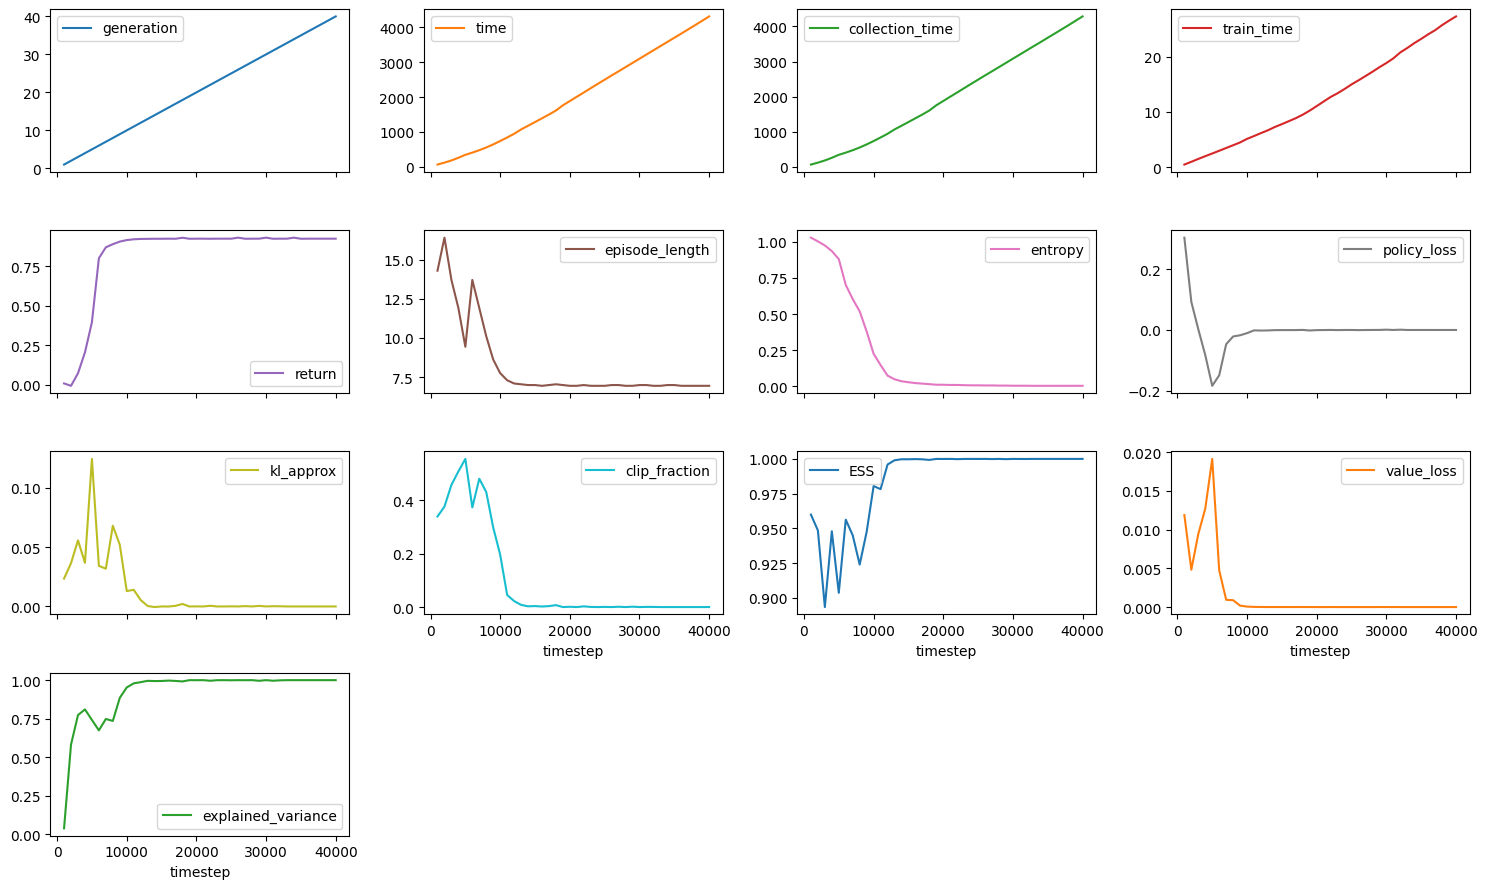

In [14]:
plot(NAME)

In [16]:
load_model(MODEL_PATH, NAME, policy, None)

In [17]:
play(lambda: create_env(graphics=True), policy, 100)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

RuntimeError: batch dimension mismatch, got self.batch_size=torch.Size([100]) and value.shape=torch.Size([]).